# CRR vs SAM Comparison Experiment

### Initialization

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms
import time
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set, Optional
from scipy.stats import pearsonr
import random
import os

print("Imports successful!")

# ============================================================================
# DEVICE AND REPRODUCIBILITY SETUP
# ============================================================================

def set_seed(s=0):
    """
    Ensure reproducibility across all random number generators.
    Critical for comparing results across different experimental conditions.
    """
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Imports successful!
Using device: cuda
GPU: NVIDIA L4


### Selective Loss Computation

In [9]:
def compute_selective_loss(model, images, labels, reg_scale=0.003,
                           target_classes=None, start_n=1, end_n=3, K_dirs=2):
    """
    Compute loss with CLASS-SELECTIVE lambda regularization.

    This is the key innovation: we can apply derivative penalties ONLY to
    specific class pairs, enabling surgical control over decision boundaries.

    Args:
        model: Neural network
        images: Input batch [B, C, H, W]
        labels: True labels [B]
        reg_scale: Strength of lambda penalty
        target_classes: Set of class indices to regularize, e.g., {4, 9}
        start_n: Starting derivative order to penalize (default: 1)
        end_n: Ending derivative order to penalize (default: 3)
        K_dirs: Number of random directions to sample per iteration (default: 2)

    Returns:
        total_loss: Cross-entropy + selective lambda penalty
        ce_loss: Just the cross-entropy component (for logging)
        reg_loss: Just the regularization component (for logging)
    """

    # Step 1: Compute standard cross-entropy loss (applies to all samples)
    logits = model(images)
    ce_loss = F.cross_entropy(logits, labels)

    # Step 2: Determine if we need regularization
    # Case 1: target_classes is an empty set → baseline, no regularization
    if target_classes is not None and len(target_classes) == 0:
        return ce_loss, ce_loss.item(), 0.0

    # Case 2: target_classes is None → global regularization on all samples
    if target_classes is None:
        # Apply penalty to all samples in batch
        reg_loss = lambda_regularizer_images(
            model, images, labels, start_n=start_n, end_n=end_n,
            K_dirs=K_dirs, scale=reg_scale
        )
        total_loss = ce_loss + reg_loss
        return total_loss, ce_loss.item(), reg_loss.item()

    # Case 3: target_classes is a non-empty set → SELECTIVE regularization
    # This is the novel contribution!

    # Filter to only images whose labels are in target_classes
    mask = torch.zeros(len(labels), dtype=torch.bool, device=labels.device)
    for target_class in target_classes:
        mask |= (labels == target_class)

    # Check if any target class samples exist in this batch
    if mask.any():
        # Extract only the target class samples
        target_images = images[mask]
        target_labels = labels[mask]

        # Compute lambda penalty ONLY on these samples
        reg_loss = lambda_regularizer_images(
            model, target_images, target_labels,
            start_n=start_n, end_n=end_n, K_dirs=K_dirs, scale=reg_scale
        )

        total_loss = ce_loss + reg_loss
        return total_loss, ce_loss.item(), reg_loss.item()
    else:
        # No target class samples in this batch → no regularization
        return ce_loss, ce_loss.item(), 0.0

### Load MNIST Data

In [10]:
def load_mnist_full(batch_size=128, label_noise=0.0, seed=42):
    """
    Load the complete MNIST dataset with optional label noise.
    """
    # Standard MNIST normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load full datasets
    train_dataset = datasets.MNIST('./data', train=True, download=True,
                                   transform=transform)
    test_dataset = datasets.MNIST('./data', train=False,
                                  transform=transform)

    # ADD LABEL NOISE TO TRAINING SET
    if label_noise > 0:
        print(f"\n⚠️  Adding {label_noise*100:.0f}% label noise to training set...")

        rng = np.random.default_rng(seed)
        n_train = len(train_dataset)
        n_corrupt = int(label_noise * n_train)

        # Get indices to corrupt
        corrupt_indices = rng.choice(n_train, size=n_corrupt, replace=False)

        # CORRECTED: Directly modify the dataset's targets tensor
        # MNIST stores labels in train_dataset.targets (a tensor)
        original_targets = train_dataset.targets.clone()

        for idx in corrupt_indices:
            old_label = original_targets[idx].item()
            # Choose from the 9 other classes
            new_label = old_label
            while new_label == old_label:
                new_label = rng.integers(0, 10)
            train_dataset.targets[idx] = new_label

        print(f"   Corrupted {n_corrupt:,} training labels")

        # Optional: Verify corruption
        n_changed = (train_dataset.targets != original_targets).sum().item()
        print(f"   Verified: {n_changed:,} labels actually changed")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=512,
                            shuffle=False, num_workers=2, pin_memory=True)

    print(f"Loaded MNIST:")
    print(f"  Training: {len(train_dataset)} images")
    print(f"  Test: {len(test_dataset)} images")
    if label_noise > 0:
        print(f"  Label noise: {label_noise*100:.0f}%")

    return train_loader, test_loader, test_dataset

def get_boundary_points_for_class_pair(model, test_dataset, class_a, class_b,
                                       prob_range=(0.30, 0.70), max_points=200):
    """
    Extract test points near the decision boundary for a specific class pair.

    This is critical for class-pair-specific λ measurement. We want points
    where the model is uncertain between the two classes.

    Args:
        model: Trained neural network
        test_dataset: Raw MNIST test dataset
        class_a: First class (e.g., 6)
        class_b: Second class (e.g., 7)
        prob_range: Probability range defining "near boundary" (default 0.3-0.7)
        max_points: Maximum number of boundary points to return

    Returns:
        boundary_images: Tensor of shape [N, 1, 28, 28] with N ≤ max_points (or None if empty)
        boundary_labels: Tensor of shape [N] with true labels (or None if empty)
        indices: Original indices in test_dataset (or empty list if no points found)
    """
    model.eval()

    # Step 1: Filter test set to only class_a and class_b samples
    class_pair_indices = []
    for idx in range(len(test_dataset)):
        _, label = test_dataset[idx]
        if label == class_a or label == class_b:
            class_pair_indices.append(idx)

    print(f"  Found {len(class_pair_indices)} total samples for classes {class_a} vs {class_b}")

    # Step 2: Create a loader for these samples
    subset = Subset(test_dataset, class_pair_indices)
    loader = DataLoader(subset, batch_size=512, shuffle=False)

    # Step 3: Compute model predictions and find boundary points
    boundary_indices_local = []  # Indices within the subset

    with torch.no_grad():
        batch_start_idx = 0
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)

            # Get probability of the predicted class
            max_probs = probs.max(dim=1).values

            # Find samples in the uncertain range
            in_range = (max_probs >= prob_range[0]) & (max_probs <= prob_range[1])

            # Store local indices (within this subset)
            local_indices = torch.where(in_range)[0].cpu().numpy()
            boundary_indices_local.extend(batch_start_idx + local_indices)

            batch_start_idx += len(images)

    print(f"  Found {len(boundary_indices_local)} boundary points (prob in [{prob_range[0]}, {prob_range[1]}])")

    # Handle case where no boundary points found
    if len(boundary_indices_local) == 0:
        print(f"  ⚠ No boundary points found - this can happen with untrained models")
        print(f"    or if prob_range is too restrictive. Returning None.")
        return None, None, []

    # Step 4: If too many points, randomly sample
    if len(boundary_indices_local) > max_points:
        boundary_indices_local = np.random.choice(
            boundary_indices_local, size=max_points, replace=False
        )
        print(f"  Sampled down to {max_points} points")

    # Step 5: Extract the actual images and labels
    boundary_images = []
    boundary_labels = []
    original_indices = []

    for local_idx in boundary_indices_local:
        original_idx = class_pair_indices[local_idx]
        image, label = test_dataset[original_idx]
        boundary_images.append(image)
        boundary_labels.append(label)
        original_indices.append(original_idx)

    # Convert to tensors
    boundary_images = torch.stack(boundary_images)
    boundary_labels = torch.tensor(boundary_labels, dtype=torch.long)

    return boundary_images, boundary_labels, original_indices

### Helper Functions

In [19]:
def sample_image_directions(B, shape=(1, 28, 28)):
    """
    Sample random unit directions in image space.

    For MNIST, inputs are 784-dimensional (1 x 28 x 28). We sample Gaussian
    random directions and normalize them to unit length.

    Args:
        B: Batch size (number of directions to sample)
        shape: Image shape (channels, height, width)

    Returns:
        Tensor of shape [B, C, H, W] containing unit-norm random directions
    """
    U = torch.randn(B, *shape, device=device)
    # Flatten to compute norms, then reshape back
    U_flat = U.view(B, -1)
    norms = U_flat.norm(dim=1, keepdim=True)
    U_flat = U_flat / (norms + 1e-12)
    return U_flat.view(B, *shape)


def lambda_regularizer_images(model, X_reg, y_reg, start_n=1, end_n=3, K_dirs=2, scale=1e-3):
    """
    Compute curvature rate regularization (CRR) penalty for image inputs.

    This function penalizes high-order directional derivatives of the loss function,
    allowing flexible specification of which derivative orders to include.

    Args:
        model: Neural network
        X_reg: Regularization batch images [B, C, H, W]
        y_reg: Labels for regularization batch [B]
        start_n: Starting derivative order to penalize (default: 1)
        end_n: Ending derivative order to penalize (default: 3)
        K_dirs: Number of random directions to sample per iteration (default: 2)
        scale: Regularization strength multiplier (default: 1e-3)

    Returns:
        Scalar regularization loss averaged across orders [start_n, end_n]

    Example:
        # Regularize only 2nd through 4th order derivatives
        loss_reg = lambda_regularizer_images(model, X, y, start_n=2, end_n=4, scale=0.1)

        # Regularize only 1st order (similar to standard gradient penalty)
        loss_reg = lambda_regularizer_images(model, X, y, start_n=1, end_n=1, scale=1.0)
    """

    # Input validation
    if start_n < 1:
        raise ValueError(f"start_n must be >= 1, got {start_n}")
    if end_n < start_n:
        raise ValueError(f"end_n ({end_n}) must be >= start_n ({start_n})")

    X_reg = X_reg.to(device).requires_grad_(True)
    y_reg = y_reg.to(device)

    reg_terms = []

    # Sample random directions once for all iterations
    U = sample_image_directions(X_reg.size(0), shape=(1, 28, 28))

    # Build computation graph through loss
    logits = model(X_reg)
    loss_i = F.cross_entropy(logits, y_reg, reduction='none')
    y_scalar = loss_i.sum()

    # We need to compute derivatives sequentially from 1 to end_n,
    # but only accumulate penalties for orders in [start_n, end_n]
    for n in range(1, end_n + 1):
        grads = torch.autograd.grad(y_scalar, X_reg, create_graph=True, retain_graph=True)[0]
        d_n = (grads * U).view(grads.size(0), -1).sum(dim=1)

        # Only penalize if n is in the requested range
        if n >= start_n:
            reg_terms.append(d_n.abs().mean())

        # Prepare for next derivative order
        y_scalar = d_n.sum()

    if len(reg_terms) == 0:
        return torch.tensor(0.0, device=device)

    return scale * torch.stack(reg_terms).mean()

def compute_ece(model, test_loader, n_bins=10):
    """
    Compute Expected Calibration Error (ECE).

    ECE measures the difference between confidence and accuracy across bins.
    Lower ECE indicates better calibration.

    Args:
        model: Neural network
        test_loader: Test data loader
        n_bins: Number of bins for calibration (default: 10)

    Returns:
        ece: Expected calibration error
        bin_accuracies: Accuracy per bin (for visualization)
    """
    model.eval()

    all_confidences = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            confidences, predictions = probs.max(dim=1)

            all_confidences.append(confidences.cpu())
            all_predictions.append(predictions.cpu())
            all_labels.append(labels)

    confidences = torch.cat(all_confidences)
    predictions = torch.cat(all_predictions)
    labels = torch.cat(all_labels)

    # Compute ECE
    ece = 0.0
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_accuracies = []

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]

        # Find samples in this confidence bin
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)

        if in_bin.sum() > 0:
            bin_acc = (predictions[in_bin] == labels[in_bin]).float().mean().item()
            bin_conf = confidences[in_bin].mean().item()
            bin_size = in_bin.sum().item()

            ece += (bin_size / len(confidences)) * abs(bin_acc - bin_conf)
            bin_accuracies.append(bin_acc)
        else:
            bin_accuracies.append(0.0)

    return ece, bin_accuracies


def compute_hard_sample_accuracy(model, test_loader, quantile=0.2):
    """
    Compute accuracy on the hardest samples (lowest confidence predictions).

    Args:
        model: Neural network
        test_loader: Test data loader
        quantile: Bottom quantile to consider as "hard" (default: 0.2 = bottom 20%)

    Returns:
        hard_acc: Accuracy on hard samples
        easy_acc: Accuracy on easy samples
        threshold: Confidence threshold separating hard/easy
    """
    model.eval()

    all_confidences = []
    all_correct = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            confidences, predictions = probs.max(dim=1)
            correct = (predictions == labels)

            all_confidences.append(confidences.cpu())
            all_correct.append(correct.cpu())

    confidences = torch.cat(all_confidences)
    correct = torch.cat(all_correct)

    # Find threshold for bottom quantile
    threshold = torch.quantile(confidences, quantile).item()

    # Separate hard and easy samples
    hard_mask = confidences <= threshold
    easy_mask = confidences > threshold

    hard_acc = correct[hard_mask].float().mean().item() if hard_mask.sum() > 0 else 0.0
    easy_acc = correct[easy_mask].float().mean().item() if easy_mask.sum() > 0 else 0.0

    return hard_acc, easy_acc, threshold


def compute_confusion_matrix(model, test_loader, num_classes=10):
    """
    Compute confusion matrix for the model.

    Args:
        model: Neural network
        test_loader: Test data loader
        num_classes: Number of classes (default: 10 for MNIST)

    Returns:
        confusion: Confusion matrix [num_classes, num_classes]
                  confusion[i][j] = # of times true class i was predicted as j
    """
    model.eval()
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.long)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            predictions = logits.argmax(dim=1)

            for true_label, pred_label in zip(labels.cpu(), predictions.cpu()):
                confusion[true_label][pred_label] += 1

    return confusion


def compute_pair_metrics(confusion_matrix, class_a, class_b):
    """
    Compute confusion rate between two specific classes.

    Args:
        confusion_matrix: Confusion matrix from compute_confusion_matrix
        class_a: First class index
        class_b: Second class index

    Returns:
        accuracy: Overall accuracy for these two classes
        confusion_rate: Rate at which class_a is confused with class_b and vice versa
    """
    # Total samples for each class
    total_a = confusion_matrix[class_a].sum().item()
    total_b = confusion_matrix[class_b].sum().item()

    # Correct predictions
    correct_a = confusion_matrix[class_a][class_a].item()
    correct_b = confusion_matrix[class_b][class_b].item()

    # Confusion counts
    a_as_b = confusion_matrix[class_a][class_b].item()
    b_as_a = confusion_matrix[class_b][class_a].item()

    # Compute metrics
    if total_a + total_b == 0:
        return 0.0, 0.0

    accuracy = (correct_a + correct_b) / (total_a + total_b)
    confusion_rate = (a_as_b + b_as_a) / (total_a + total_b)

    return accuracy, confusion_rate


def measure_lambda_for_pair(model, boundary_images, boundary_labels, n_max=4, K_dirs=2):
    """
    Measure λ for a specific set of boundary samples.

    Args:
        model: Neural network
        boundary_images: Images near decision boundary [N, 1, 28, 28]
        boundary_labels: True labels [N]
        n_max: Maximum derivative order to compute
        K_dirs: Number of random directions to sample

    Returns:
        lambda_value: Mean λ across all samples and directions
    """
    if boundary_images is None or len(boundary_images) == 0:
        return None

    model.eval()

    lambda_values = []

    # Process in small batches to avoid memory issues
    batch_size = 32
    for i in range(0, len(boundary_images), batch_size):
        batch_images = boundary_images[i:i+batch_size].to(device)
        batch_labels = boundary_labels[i:i+batch_size].to(device)

        # Sample random directions
        U = sample_image_directions(len(batch_images), shape=(1, 28, 28))

        # Compute derivatives
        X = batch_images.clone().detach().requires_grad_(True)
        logits = model(X)
        loss_i = F.cross_entropy(logits, batch_labels, reduction='none')
        y_scalar = loss_i.sum()

        derivatives = []
        for n in range(1, n_max + 1):
            grads = torch.autograd.grad(y_scalar, X, create_graph=True, retain_graph=True)[0]
            d_n = (grads * U).view(grads.size(0), -1).sum(dim=1)
            derivatives.append(d_n.detach().abs())
            y_scalar = d_n.sum()

        # Compute λ for each sample
        for sample_idx in range(len(batch_images)):
            sample_derivs = [d[sample_idx].item() for d in derivatives]
            if len(sample_derivs) >= 2 and sample_derivs[0] > 1e-8:
                # λ ≈ log(d_n+1 / d_n)
                ratios = [sample_derivs[i+1] / (sample_derivs[i] + 1e-12)
                         for i in range(len(sample_derivs) - 1)]
                lambda_val = np.mean([np.log(r + 1e-12) for r in ratios])
                lambda_values.append(lambda_val)

    if len(lambda_values) == 0:
        return None

    return np.mean(lambda_values)


def measure_all_class_pairs(model, test_dataset, class_pairs=[(4, 9), (3, 8), (6, 7)]):
    """
    Measure λ for multiple class pairs.

    Args:
        model: Neural network
        test_dataset: Raw test dataset
        class_pairs: List of (class_a, class_b) tuples

    Returns:
        measurements: Dict with keys like '4v9' containing λ values
    """
    measurements = {}

    for class_a, class_b in class_pairs:
        print(f"\n  Measuring λ for classes {class_a} vs {class_b}...")

        # Get boundary points
        boundary_images, boundary_labels, _ = get_boundary_points_for_class_pair(
            model, test_dataset, class_a, class_b,
            prob_range=(0.30, 0.70), max_points=200
        )

        # Measure λ
        lambda_val = measure_lambda_for_pair(
            model, boundary_images, boundary_labels, n_max=4, K_dirs=2
        )

        key = f"{class_a}v{class_b}"
        measurements[key] = {
            'lambda': lambda_val,
            'n_boundary_points': len(boundary_images) if boundary_images is not None else 0
        }

        if lambda_val is not None:
            print(f"    λ({class_a}v{class_b}) = {lambda_val:.4f}")
        else:
            print(f"    λ({class_a}v{class_b}) = None (no boundary points)")

    return measurements

### MNIST Initialization

In [12]:
class MNISTConvNet(nn.Module):
    """
    Standard CNN for MNIST classification.

    Architecture:
    - Conv1: 1 → 32 channels, 3x3 kernel, ReLU
    - Conv2: 32 → 64 channels, 3x3 kernel, ReLU
    - MaxPool: 2x2 after each conv
    - Dropout: 0.5 after pooling
    - FC1: 9216 → 128 hidden units, ReLU
    - FC2: 128 → 10 output classes

    This architecture is deliberately simple and matches your previous MNIST
    experiments, ensuring results are comparable.
    """
    def __init__(self, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        # After Conv1: 28→26, Conv2: 26→24, MaxPool: 24→12
        # So: 64 * 12 * 12 = 9216
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)  # [B, 1, 28, 28] → [B, 32, 26, 26]
        x = F.relu(x)

        # Conv block 2
        x = self.conv2(x)  # [B, 32, 26, 26] → [B, 64, 24, 24]
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # [B, 64, 24, 24] → [B, 64, 12, 12]
        x = self.dropout1(x)

        # Fully connected layers
        x = torch.flatten(x, 1)  # [B, 64, 12, 12] → [B, 9216]
        x = self.fc1(x)  # [B, 9216] → [B, 128]
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # [B, 128] → [B, 10]

        return x


### SAM Optimizer

In [13]:
class SAM(Optimizer):
    """
    Sharpness Aware Minimization (SAM) optimizer.

    SAM finds parameters that have uniformly low loss across a neighborhood,
    not just at a single point. This leads to flatter minima and better generalization.

    Reference: "Sharpness-Aware Minimization for Efficiently Improving Generalization"
               (Foret et al., ICLR 2021)

    Args:
        params: Model parameters to optimize
        base_optimizer: Underlying optimizer (e.g., Adam, SGD)
        rho: Size of the perturbation neighborhood (default: 0.05)
        adaptive: Use adaptive rho based on parameter norms (default: False)
    """
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        """
        First step: compute and apply perturbation that maximizes loss.
        """
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                # Save current parameter value
                self.state[p]["old_p"] = p.data.clone()

                # Compute perturbation
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)

                # Apply perturbation (ascent step to find worst-case)
                p.add_(e_w)

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        """
        Second step: restore original parameters and update using gradient at perturbed point.
        """
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                # Restore original parameter value
                p.data = self.state[p]["old_p"]

        # Update with base optimizer using the gradient at the perturbed point
        self.base_optimizer.step()

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        """
        Combined step (for compatibility, but SAM requires manual first/second step).
        """
        assert closure is not None, "SAM requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)

        # First step: find adversarial perturbation
        self.first_step(zero_grad=True)

        # Re-evaluate loss at perturbed point
        closure()

        # Second step: update parameters
        self.second_step()

    def _grad_norm(self):
        """Compute gradient norm across all parameters."""
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
            torch.stack([
                ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                for group in self.param_groups for p in group["params"]
                if p.grad is not None
            ]),
            p=2
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups


### Training Functions

In [14]:
def train_mnist_selective(train_loader, test_loader,
                          condition='baseline',
                          reg_scale=0.003,
                          start_n=1,
                          end_n=3,
                          epochs=15,
                          lr=1e-3,
                          seed=0,
                          verbose=True):
    """
    Train MNIST model with class-selective regularization.

    Args:
        train_loader: DataLoader for training
        test_loader: DataLoader for testing
        condition: One of ['baseline', 'global', 'selective_49', 'selective_38']
        reg_scale: Regularization strength
        start_n: Starting derivative order to penalize (default: 1)
        end_n: Ending derivative order to penalize (default: 3)
        epochs: Number of training epochs
        lr: Learning rate
        seed: Random seed
        verbose: Print progress

    Returns:
        model: Trained model
        history: Dict with training metrics over time
    """

    # Set seed for reproducibility
    set_seed(seed)

    # Define target classes based on condition
    # Using more confusable pairs: 4/9 and 3/8
    if condition == 'baseline':
        target_classes = set()
        condition_name = "Baseline (no reg)"
    elif condition == 'global':
        target_classes = None
        condition_name = "Global regularization"
    elif condition == 'selective_49':
        target_classes = {4, 9}  # CHANGED: 4 vs 9 are naturally confusable
        condition_name = "Selective 4/9 regularization"
    elif condition == 'selective_38':
        target_classes = {3, 8}  # CHANGED: 3 vs 8 are naturally confusable
        condition_name = "Selective 3/8 regularization"
    else:
        raise ValueError(f"Unknown condition: {condition}")

    if verbose:
        print(f"\n{'='*70}")
        print(f"Training: {condition_name} (seed={seed})")
        print(f"{'='*70}")

    # Initialize model and optimizer
    model = MNISTConvNet(dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # History tracking
    history = {
        'condition': condition,
        'seed': seed,
        'train_loss': [],
        'train_ce_loss': [],
        'train_reg_loss': [],
        'test_acc': [],
        'test_loss': [],
        'epoch_times': []
    }

    # Training loop
    for epoch in range(epochs):
        epoch_start = time.time()

        # ==================== TRAINING ====================
        model.train()
        train_loss_sum = 0.0
        train_ce_sum = 0.0
        train_reg_sum = 0.0
        n_batches = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Compute loss with selective regularization
            loss, ce_loss, reg_loss = compute_selective_loss(
                model, images, labels,
                reg_scale=reg_scale,
                target_classes=target_classes,
                start_n=start_n,
                end_n=end_n,
                K_dirs=2
            )

            loss.backward()
            optimizer.step()

            # Track losses
            train_loss_sum += loss.item()
            train_ce_sum += ce_loss
            train_reg_sum += reg_loss
            n_batches += 1

        # Average losses
        avg_train_loss = train_loss_sum / n_batches
        avg_train_ce = train_ce_sum / n_batches
        avg_train_reg = train_reg_sum / n_batches

        # ==================== EVALUATION ====================
        model.eval()
        test_loss_sum = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)

                # Test loss
                test_loss_sum += F.cross_entropy(logits, labels, reduction='sum').item()

                # Test accuracy
                pred = logits.argmax(dim=1)
                correct += (pred == labels).sum().item()
                total += labels.size(0)

        test_loss = test_loss_sum / total
        test_acc = correct / total

        # Record history
        history['train_loss'].append(avg_train_loss)
        history['train_ce_loss'].append(avg_train_ce)
        history['train_reg_loss'].append(avg_train_reg)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['epoch_times'].append(time.time() - epoch_start)

        # Print progress
        if verbose and (epoch + 1) % 3 == 0:
            print(f"  Epoch {epoch+1:2d}/{epochs}: "
                  f"train_loss={avg_train_loss:.4f}, "
                  f"test_acc={test_acc:.4f}, "
                  f"reg_loss={avg_train_reg:.4f}")

    if verbose:
        total_time = sum(history['epoch_times'])
        print(f"\nTraining complete! Total time: {total_time:.1f}s")
        print(f"Final test accuracy: {history['test_acc'][-1]:.4f}")

    return model, history

def train_with_sam(train_loader, test_loader, epochs=15, lr=1e-3, rho=0.05, seed=0, verbose=True):
    """
    Train a model using SAM optimizer.

    Args:
        train_loader: Training data loader
        test_loader: Test data loader
        epochs: Number of training epochs
        lr: Learning rate
        rho: SAM perturbation radius (default 0.05)
        seed: Random seed
        verbose: Print progress

    Returns:
        model: Trained model
        history: Training history dict
    """
    set_seed(seed)

    if verbose:
        print(f"\n{'='*70}")
        print(f"Training with SAM (rho={rho}, seed={seed})")
        print(f"{'='*70}")

    # Initialize model
    model = MNISTConvNet(dropout=0.5).to(device)

    # Create SAM optimizer with Adam as base
    base_opt = torch.optim.Adam
    optimizer = SAM(model.parameters(), base_opt, lr=lr, rho=rho)

    # History tracking
    history = {
        'train_loss': [],
        'test_acc': [],
        'test_loss': [],
        'epoch_times': []
    }

    # Training loop
    for epoch in range(epochs):
        epoch_start = time.time()

        # ==================== TRAINING ====================
        model.train()
        train_loss_sum = 0.0
        n_batches = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Define closure for SAM
            def closure():
                optimizer.zero_grad()
                logits = model(images)
                loss = F.cross_entropy(logits, labels)
                loss.backward()
                return loss

            # SAM's two-step process
            # First step: find adversarial perturbation
            loss = closure()
            optimizer.first_step(zero_grad=True)

            # Second step: compute gradient at perturbed point and update
            closure()
            optimizer.second_step(zero_grad=True)

            train_loss_sum += loss.item()
            n_batches += 1

        avg_train_loss = train_loss_sum / n_batches

        # ==================== EVALUATION ====================
        model.eval()
        test_loss_sum = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)

                test_loss_sum += F.cross_entropy(logits, labels, reduction='sum').item()
                pred = logits.argmax(dim=1)
                correct += (pred == labels).sum().item()
                total += labels.size(0)

        test_loss = test_loss_sum / total
        test_acc = correct / total

        # Record history
        history['train_loss'].append(avg_train_loss)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['epoch_times'].append(time.time() - epoch_start)

        if verbose and (epoch + 1) % 3 == 0:
            print(f"  Epoch {epoch+1:2d}/{epochs}: "
                  f"train_loss={avg_train_loss:.4f}, "
                  f"test_acc={test_acc:.4f}")

    if verbose:
        total_time = sum(history['epoch_times'])
        print(f"\nTraining complete! Total time: {total_time:.1f}s")
        print(f"Final test accuracy: {history['test_acc'][-1]:.4f}")

    return model, history


def train_with_lambda(train_loader, test_loader, epochs=15, lr=1e-3,
                     reg_scale=100.0, start_n=1, end_n=3, seed=0, verbose=True):
    """
    Train a model using λ-regularization (global).

    Args:
        train_loader: Training data loader
        test_loader: Test data loader
        epochs: Number of training epochs
        lr: Learning rate
        reg_scale: Lambda regularization strength
        start_n: Starting derivative order to penalize (default: 1)
        end_n: Ending derivative order to penalize (default: 3)
        seed: Random seed
        verbose: Print progress

    Returns:
        model: Trained model
        history: Training history dict
    """
    set_seed(seed)

    if verbose:
        print(f"\n{'='*70}")
        print(f"Training with λ-regularization (scale={reg_scale}, orders={start_n}-{end_n}, seed={seed})")
        print(f"{'='*70}")

    # Use the existing training function with global regularization
    model, history = train_mnist_selective(
        train_loader, test_loader,
        condition='global',  # Global lambda regularization
        reg_scale=reg_scale,
        start_n=start_n,
        end_n=end_n,
        epochs=epochs,
        lr=lr,
        seed=seed,
        verbose=verbose
    )

    return model, history



### Evalutation

In [15]:
@dataclass
class ComparisonResult:
    """Store comprehensive evaluation metrics for comparison."""
    method: str
    seed: int

    # Basic metrics
    test_acc: float
    test_loss: float

    # Calibration
    ece: float

    # Hard samples
    hard_acc_20pct: float
    hard_threshold: float

    # Confusion rates for confusable pairs
    confusion_4v9: float
    confusion_3v8: float
    confusion_6v7: float

    # Lambda values
    lambda_4v9: float
    lambda_3v8: float
    lambda_6v7: float

    # Training time
    train_time: float


def evaluate_model_comprehensive(model, test_loader, test_dataset, method_name, seed, train_time):
    """
    Comprehensively evaluate a model on all metrics.

    Returns:
        ComparisonResult object with all metrics
    """
    print(f"\n  Evaluating {method_name} (seed {seed})...")

    # Basic metrics
    model.eval()
    test_loss_sum = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            test_loss_sum += F.cross_entropy(logits, labels, reduction='sum').item()
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss_sum / total
    test_acc = correct / total

    # Calibration (ECE)
    ece, _ = compute_ece(model, test_loader, n_bins=10)

    # Hard samples (bottom 20%)
    hard_acc, _, hard_threshold = compute_hard_sample_accuracy(model, test_loader, quantile=0.2)

    # Confusion matrix and pair metrics
    confusion = compute_confusion_matrix(model, test_loader, num_classes=10)
    _, conf_4v9 = compute_pair_metrics(confusion, 4, 9)
    _, conf_3v8 = compute_pair_metrics(confusion, 3, 8)
    _, conf_6v7 = compute_pair_metrics(confusion, 6, 7)

    # Lambda measurements for class pairs
    lambda_measurements = measure_all_class_pairs(
        model, test_dataset,
        class_pairs=[(4, 9), (3, 8), (6, 7)]
    )

    result = ComparisonResult(
        method=method_name,
        seed=seed,
        test_acc=test_acc,
        test_loss=test_loss,
        ece=ece,
        hard_acc_20pct=hard_acc,
        hard_threshold=hard_threshold,
        confusion_4v9=conf_4v9,
        confusion_3v8=conf_3v8,
        confusion_6v7=conf_6v7,
        lambda_4v9=lambda_measurements['4v9']['lambda'],
        lambda_3v8=lambda_measurements['3v8']['lambda'],
        lambda_6v7=lambda_measurements['6v7']['lambda'],
        train_time=train_time
    )

    print(f"    Test Acc: {test_acc:.4f} | ECE: {ece:.4f} | Hard 20%: {hard_acc:.4f}")

    return result


### Run Comparison Experiment

In [16]:
def run_sam_vs_lambda_comparison(seeds=[0, 1, 2], epochs=15,
                                  sam_rho=0.05, lambda_scale=100.0,
                                  lambda_start_n=1, lambda_end_n=3,
                                  verbose=True):
    """
    Run complete comparison: SAM vs λ-regularization.

    Args:
        seeds: List of random seeds to use
        epochs: Number of training epochs
        sam_rho: SAM perturbation radius
        lambda_scale: Lambda regularization strength
        lambda_start_n: Starting derivative order for lambda (default: 1)
        lambda_end_n: Ending derivative order for lambda (default: 3)
        verbose: Print detailed progress

    Returns:
        results: List of ComparisonResult objects
    """
    print("\n" + "="*80)
    print("SAM VS λ-REGULARIZATION COMPARISON")
    print("="*80)
    print(f"\nSettings:")
    print(f"  Seeds: {seeds}")
    print(f"  Epochs: {epochs}")
    print(f"  SAM rho: {sam_rho}")
    print(f"  Lambda scale: {lambda_scale}")
    print(f"  Lambda derivative orders: {lambda_start_n}-{lambda_end_n}")
    print("="*80)

    # Load data
    train_loader, test_loader, test_dataset = load_mnist_full(
        batch_size=128,
        label_noise=0.0,  # 20% label noise to match your experiments
        seed=42
    )

    results = []

    # Train models for each seed
    for seed in seeds:
        print(f"\n{'='*80}")
        print(f"SEED {seed}")
        print(f"{'='*80}")

        # ========== TRAIN WITH SAM ==========
        start_time = time.time()
        sam_model, sam_history = train_with_sam(
            train_loader, test_loader,
            epochs=epochs, lr=1e-3, rho=sam_rho, seed=seed, verbose=verbose
        )
        sam_time = time.time() - start_time

        # Evaluate SAM model
        sam_result = evaluate_model_comprehensive(
            sam_model, test_loader, test_dataset,
            method_name='SAM', seed=seed, train_time=sam_time
        )
        results.append(sam_result)

        # Clean up
        del sam_model
        torch.cuda.empty_cache()

        # ========== TRAIN WITH LAMBDA ==========
        start_time = time.time()
        lambda_model, lambda_history = train_with_lambda(
            train_loader, test_loader,
            epochs=epochs, lr=1e-3, reg_scale=lambda_scale,
            start_n=lambda_start_n, end_n=lambda_end_n,
            seed=seed, verbose=verbose
        )
        lambda_time = time.time() - start_time

        # Evaluate Lambda model
        lambda_result = evaluate_model_comprehensive(
            lambda_model, test_loader, test_dataset,
            method_name='Lambda', seed=seed, train_time=lambda_time
        )
        results.append(lambda_result)

        # Clean up
        del lambda_model
        torch.cuda.empty_cache()

    return results

### Results Analysis & Visualization

In [17]:
def print_comparison_summary(results):
    """Print comprehensive comparison table."""

    # Separate results by method
    sam_results = [r for r in results if r.method == 'SAM']
    lambda_results = [r for r in results if r.method == 'Lambda']

    print("\n" + "="*100)
    print("COMPREHENSIVE COMPARISON: SAM VS λ-REGULARIZATION")
    print("="*100)

    print(f"\n{'Metric':<25} {'SAM':<25} {'Lambda':<25} {'Winner':<15}")
    print("-"*100)

    # Helper to compute mean±std
    def mean_std(vals):
        return f"{np.mean(vals):.4f}±{np.std(vals):.4f}"

    # Helper to determine winner
    def winner(sam_vals, lambda_vals, lower_better=False):
        sam_mean = np.mean(sam_vals)
        lambda_mean = np.mean(lambda_vals)
        if lower_better:
            return "λ-reg" if lambda_mean < sam_mean else "SAM"
        else:
            return "λ-reg" if lambda_mean > sam_mean else "SAM"

    # Test Accuracy (higher is better)
    sam_acc = [r.test_acc for r in sam_results]
    lambda_acc = [r.test_acc for r in lambda_results]
    print(f"{'Test Accuracy':<25} {mean_std(sam_acc):<25} {mean_std(lambda_acc):<25} {winner(sam_acc, lambda_acc):<15}")

    # ECE (lower is better)
    sam_ece = [r.ece for r in sam_results]
    lambda_ece = [r.ece for r in lambda_results]
    print(f"{'ECE (Calibration)':<25} {mean_std(sam_ece):<25} {mean_std(lambda_ece):<25} {winner(sam_ece, lambda_ece, lower_better=True):<15}")

    # Hard Sample Accuracy (higher is better)
    sam_hard = [r.hard_acc_20pct for r in sam_results]
    lambda_hard = [r.hard_acc_20pct for r in lambda_results]
    print(f"{'Hard 20% Accuracy':<25} {mean_std(sam_hard):<25} {mean_std(lambda_hard):<25} {winner(sam_hard, lambda_hard):<15}")

    print("\n" + "-"*100)
    print("CONFUSION RATES (Lower is Better)")
    print("-"*100)

    # Confusion 4/9
    sam_conf_49 = [r.confusion_4v9 for r in sam_results]
    lambda_conf_49 = [r.confusion_4v9 for r in lambda_results]  # ✓ FIXED
    print(f"{'4/9 Confusion':<25} {mean_std(sam_conf_49):<25} {mean_std(lambda_conf_49):<25} {winner(sam_conf_49, lambda_conf_49, lower_better=True):<15}")

    # Confusion 3/8
    sam_conf_38 = [r.confusion_3v8 for r in sam_results]
    lambda_conf_38 = [r.confusion_3v8 for r in lambda_results]
    print(f"{'3/8 Confusion':<25} {mean_std(sam_conf_38):<25} {mean_std(lambda_conf_38):<25} {winner(sam_conf_38, lambda_conf_38, lower_better=True):<15}")

    # Confusion 6/7
    sam_conf_67 = [r.confusion_6v7 for r in sam_results]
    lambda_conf_67 = [r.confusion_6v7 for r in lambda_results]
    print(f"{'6/7 Confusion':<25} {mean_std(sam_conf_67):<25} {mean_std(lambda_conf_67):<25} {winner(sam_conf_67, lambda_conf_67, lower_better=True):<15}")

    print("\n" + "-"*100)
    print("LAMBDA VALUES (More Negative = Flatter)")
    print("-"*100)

    # Lambda 4v9
    sam_lambda_49 = [r.lambda_4v9 for r in sam_results if r.lambda_4v9 is not None]
    lambda_lambda_49 = [r.lambda_4v9 for r in lambda_results if r.lambda_4v9 is not None]
    print(f"{'λ(4v9)':<25} {mean_std(sam_lambda_49):<25} {mean_std(lambda_lambda_49):<25} {winner(sam_lambda_49, lambda_lambda_49, lower_better=True):<15}")

    # Lambda 3v8
    sam_lambda_38 = [r.lambda_3v8 for r in sam_results if r.lambda_3v8 is not None]
    lambda_lambda_38 = [r.lambda_3v8 for r in lambda_results if r.lambda_3v8 is not None]
    print(f"{'λ(3v8)':<25} {mean_std(sam_lambda_38):<25} {mean_std(lambda_lambda_38):<25} {winner(sam_lambda_38, lambda_lambda_38, lower_better=True):<15}")

    # Lambda 6v7
    sam_lambda_67 = [r.lambda_6v7 for r in sam_results if r.lambda_6v7 is not None]
    lambda_lambda_67 = [r.lambda_6v7 for r in lambda_results if r.lambda_6v7 is not None]
    print(f"{'λ(6v7)':<25} {mean_std(sam_lambda_67):<25} {mean_std(lambda_lambda_67):<25} {winner(sam_lambda_67, lambda_lambda_67, lower_better=True):<15}")

    print("\n" + "-"*100)
    print("TRAINING TIME")
    print("-"*100)

    sam_time = [r.train_time for r in sam_results]
    lambda_time = [r.train_time for r in lambda_results]
    print(f"{'Training Time (s)':<25} {mean_std(sam_time):<25} {mean_std(lambda_time):<25}")

    print("\n" + "="*100)


def plot_comparison(results):
    """Create visualization comparing SAM and Lambda."""

    sam_results = [r for r in results if r.method == 'SAM']
    lambda_results = [r for r in results if r.method == 'Lambda']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('SAM vs λ-Regularization Comparison', fontsize=16, fontweight='bold')

    # Helper function to plot comparison
    def plot_metric(ax, sam_vals, lambda_vals, title, ylabel, lower_better=False):
        methods = ['SAM', 'λ-Reg']
        means = [np.mean(sam_vals), np.mean(lambda_vals)]
        stds = [np.std(sam_vals), np.std(lambda_vals)]

        colors = ['#ff7f0e', '#2ca02c']
        bars = ax.bar(methods, means, yerr=stds, capsize=10, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

        # Highlight the winner
        if lower_better:
            winner_idx = 0 if means[0] < means[1] else 1
        else:
            winner_idx = 0 if means[0] > means[1] else 1
        bars[winner_idx].set_edgecolor('gold')
        bars[winner_idx].set_linewidth(4)

        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, (m, s) in enumerate(zip(means, stds)):
            ax.text(i, m + s + 0.01, f'{m:.4f}', ha='center', fontsize=10, fontweight='bold')

    # Plot 1: Test Accuracy
    plot_metric(axes[0, 0],
                [r.test_acc for r in sam_results],
                [r.test_acc for r in lambda_results],
                'Test Accuracy (Higher Better)', 'Accuracy')

    # Plot 2: ECE
    plot_metric(axes[0, 1],
                [r.ece for r in sam_results],
                [r.ece for r in lambda_results],
                'Expected Calibration Error (Lower Better)', 'ECE', lower_better=True)

    # Plot 3: Hard Sample Accuracy
    plot_metric(axes[0, 2],
                [r.hard_acc_20pct for r in sam_results],
                [r.hard_acc_20pct for r in lambda_results],
                'Hard 20% Accuracy (Higher Better)', 'Accuracy')

    # Plot 4: Confusion 4/9
    plot_metric(axes[1, 0],
                [r.confusion_4v9 for r in sam_results],
                [r.confusion_4v9 for r in lambda_results],
                '4/9 Confusion Rate (Lower Better)', 'Confusion Rate', lower_better=True)

    # Plot 5: Lambda 4v9
    plot_metric(axes[1, 1],
                [r.lambda_4v9 for r in sam_results if r.lambda_4v9 is not None],
                [r.lambda_4v9 for r in lambda_results if r.lambda_4v9 is not None],
                'λ(4v9) Curvature (More Negative Better)', 'λ Value', lower_better=True)

    # Plot 6: Training Time
    plot_metric(axes[1, 2],
                [r.train_time for r in sam_results],
                [r.train_time for r in lambda_results],
                'Training Time', 'Time (seconds)', lower_better=True)

    plt.tight_layout()

    # Save figure
    plt.savefig('/mnt/user-data/outputs/sam_vs_lambda_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved plot to: /mnt/user-data/outputs/sam_vs_lambda_comparison.png")
    plt.show()


### Run Comparison


SAM VS λ-REGULARIZATION COMPARISON

Settings:
  Seeds: [0, 1, 2]
  Epochs: 30
  SAM rho: 0.05
  Lambda scale: 200.0
  Lambda derivative orders: 2-4
Loaded MNIST:
  Training: 60000 images
  Test: 10000 images

SEED 0

Training with SAM (rho=0.05, seed=0)
  Epoch  3/30: train_loss=0.0698, test_acc=0.9882
  Epoch  6/30: train_loss=0.0475, test_acc=0.9905
  Epoch  9/30: train_loss=0.0352, test_acc=0.9927
  Epoch 12/30: train_loss=0.0302, test_acc=0.9927
  Epoch 15/30: train_loss=0.0255, test_acc=0.9926
  Epoch 18/30: train_loss=0.0240, test_acc=0.9918
  Epoch 21/30: train_loss=0.0189, test_acc=0.9930
  Epoch 24/30: train_loss=0.0195, test_acc=0.9933
  Epoch 27/30: train_loss=0.0161, test_acc=0.9924
  Epoch 30/30: train_loss=0.0173, test_acc=0.9929

Training complete! Total time: 235.1s
Final test accuracy: 0.9929

  Evaluating SAM (seed 0)...

  Measuring λ for classes 4 vs 9...
  Found 1991 total samples for classes 4 vs 9
  Found 13 boundary points (prob in [0.3, 0.7])
    λ(4v9) = -2.1

/tmp/ipython-input-3209560940.py:162: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/sam_vs_lambda_comparison.png'

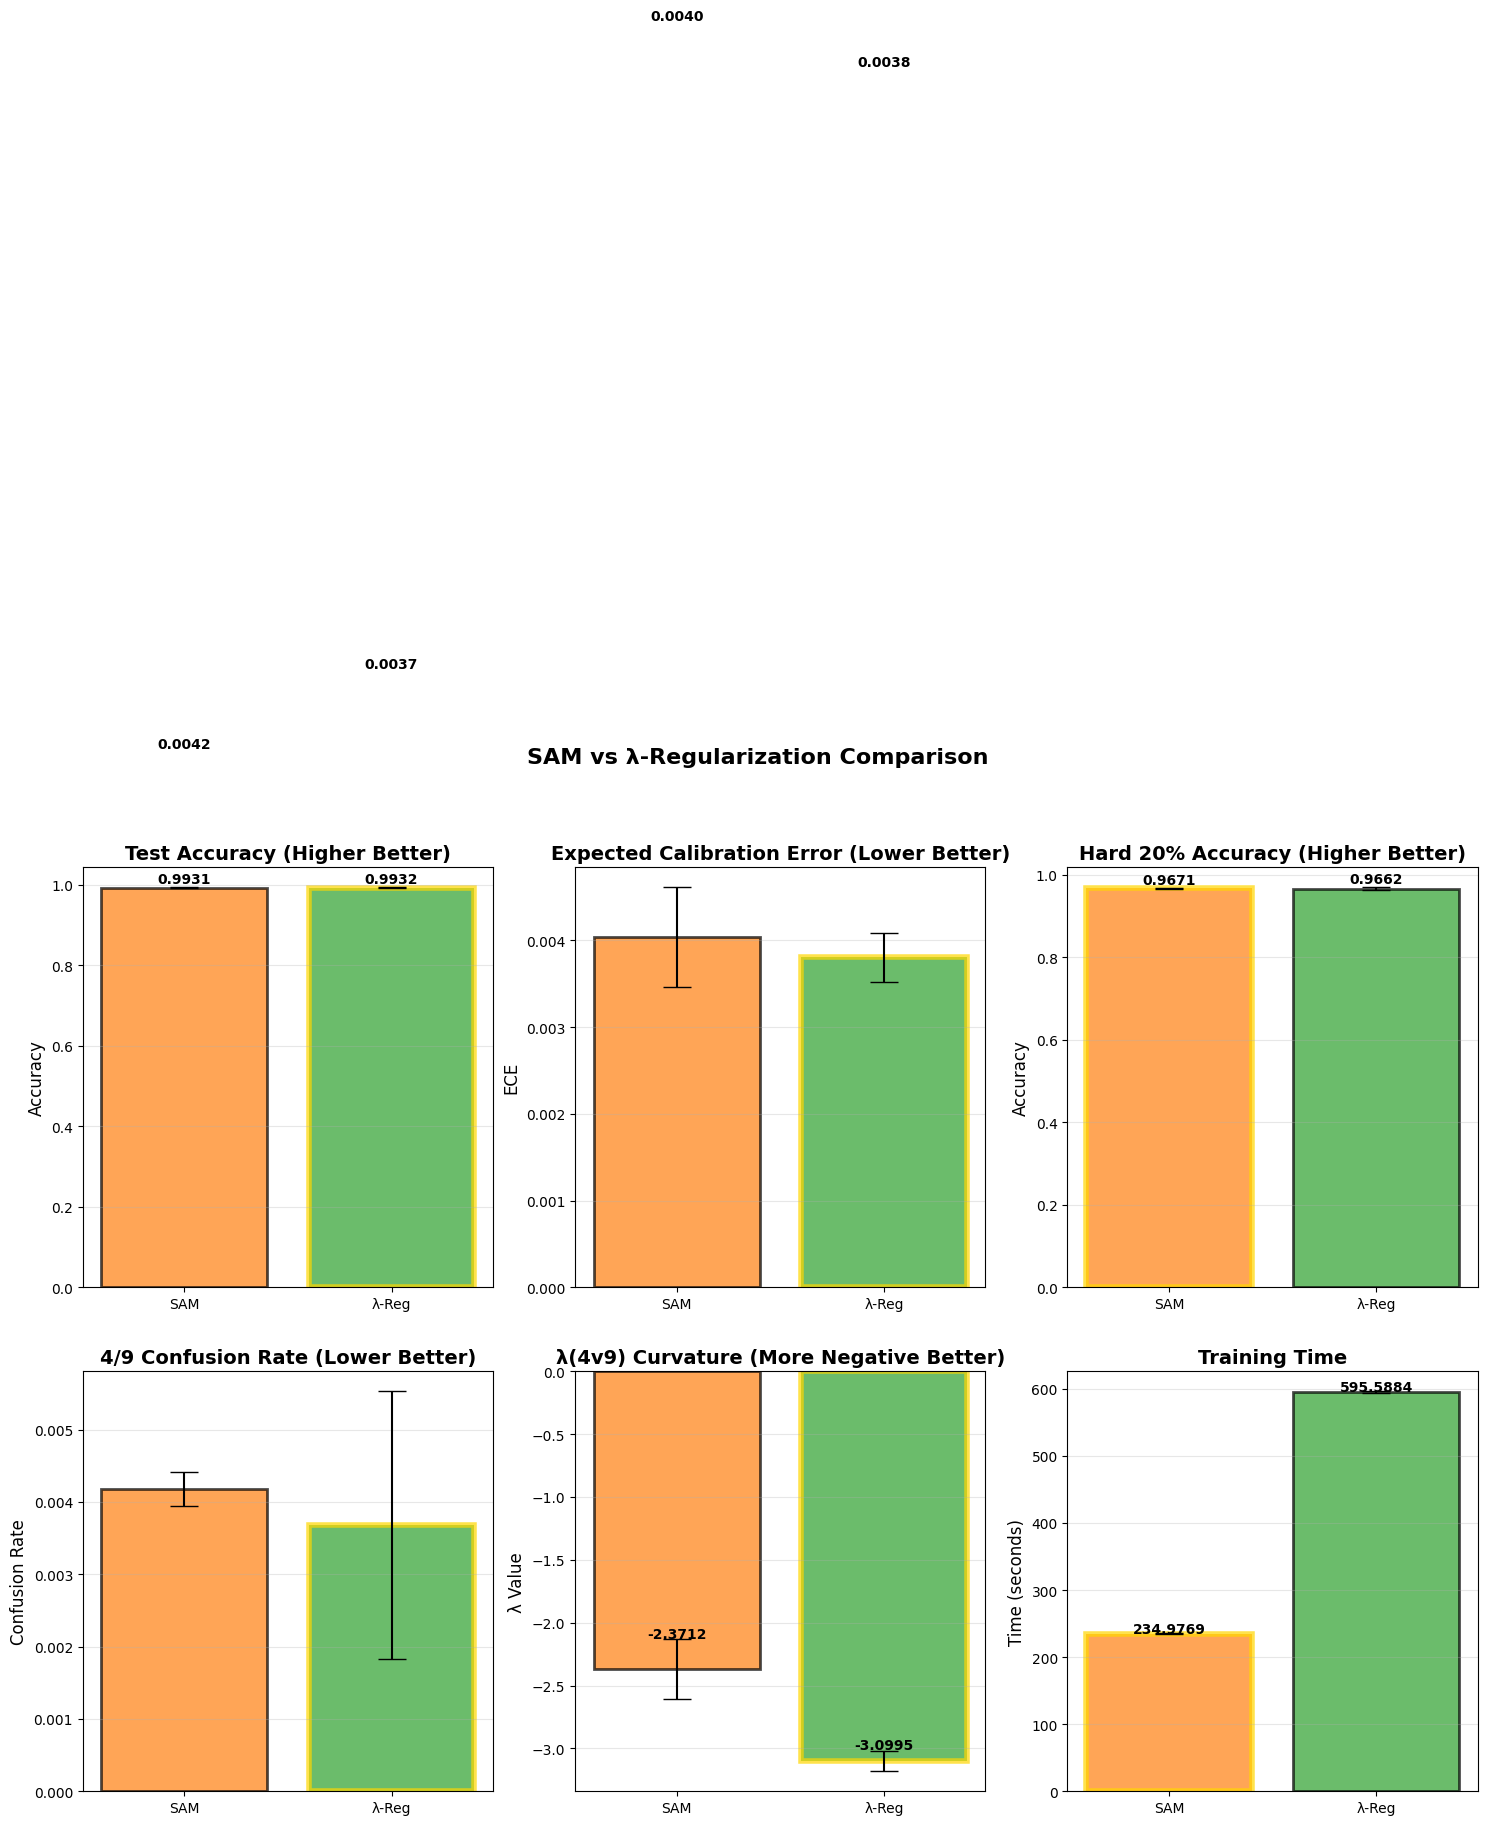

In [20]:
# Run the comparison
comparison_results = run_sam_vs_lambda_comparison(
    seeds=[0, 1, 2],
    epochs=30,
    sam_rho=0.05,        # Standard SAM rho value
    lambda_scale=200.0,  # Your λ regularization strength
    lambda_start_n=2,    # Specify which derivative orders to penalize
    lambda_end_n=4,      # Default: 1st through 3rd order
    verbose=True
)

# Analyze and visualize results
print_comparison_summary(comparison_results)
plot_comparison(comparison_results)



SAM VS λ-REGULARIZATION COMPARISON

Settings:
  Seeds: [0, 1, 2]
  Epochs: 30
  SAM rho: 0.05
  Lambda scale: 200.0
  Lambda derivative orders: 1-4
Loaded MNIST:
  Training: 60000 images
  Test: 10000 images

SEED 0

Training with λ-regularization (scale=200.0, orders=1-4, seed=0)

Training: Global regularization (seed=0)
  Epoch  3/30: train_loss=0.1631, test_acc=0.9885, reg_loss=0.0766
  Epoch  6/30: train_loss=0.1305, test_acc=0.9890, reg_loss=0.0671
  Epoch  9/30: train_loss=0.1160, test_acc=0.9921, reg_loss=0.0613
  Epoch 12/30: train_loss=0.1061, test_acc=0.9920, reg_loss=0.0580
  Epoch 15/30: train_loss=0.0953, test_acc=0.9928, reg_loss=0.0531
  Epoch 18/30: train_loss=0.0886, test_acc=0.9912, reg_loss=0.0497
  Epoch 21/30: train_loss=0.0823, test_acc=0.9925, reg_loss=0.0480
  Epoch 24/30: train_loss=0.0782, test_acc=0.9936, reg_loss=0.0456
  Epoch 27/30: train_loss=0.0761, test_acc=0.9932, reg_loss=0.0464
  Epoch 30/30: train_loss=0.0731, test_acc=0.9933, reg_loss=0.0441

Trai

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-3209560940.py:162: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/sam_vs_lambda_comparison.png'

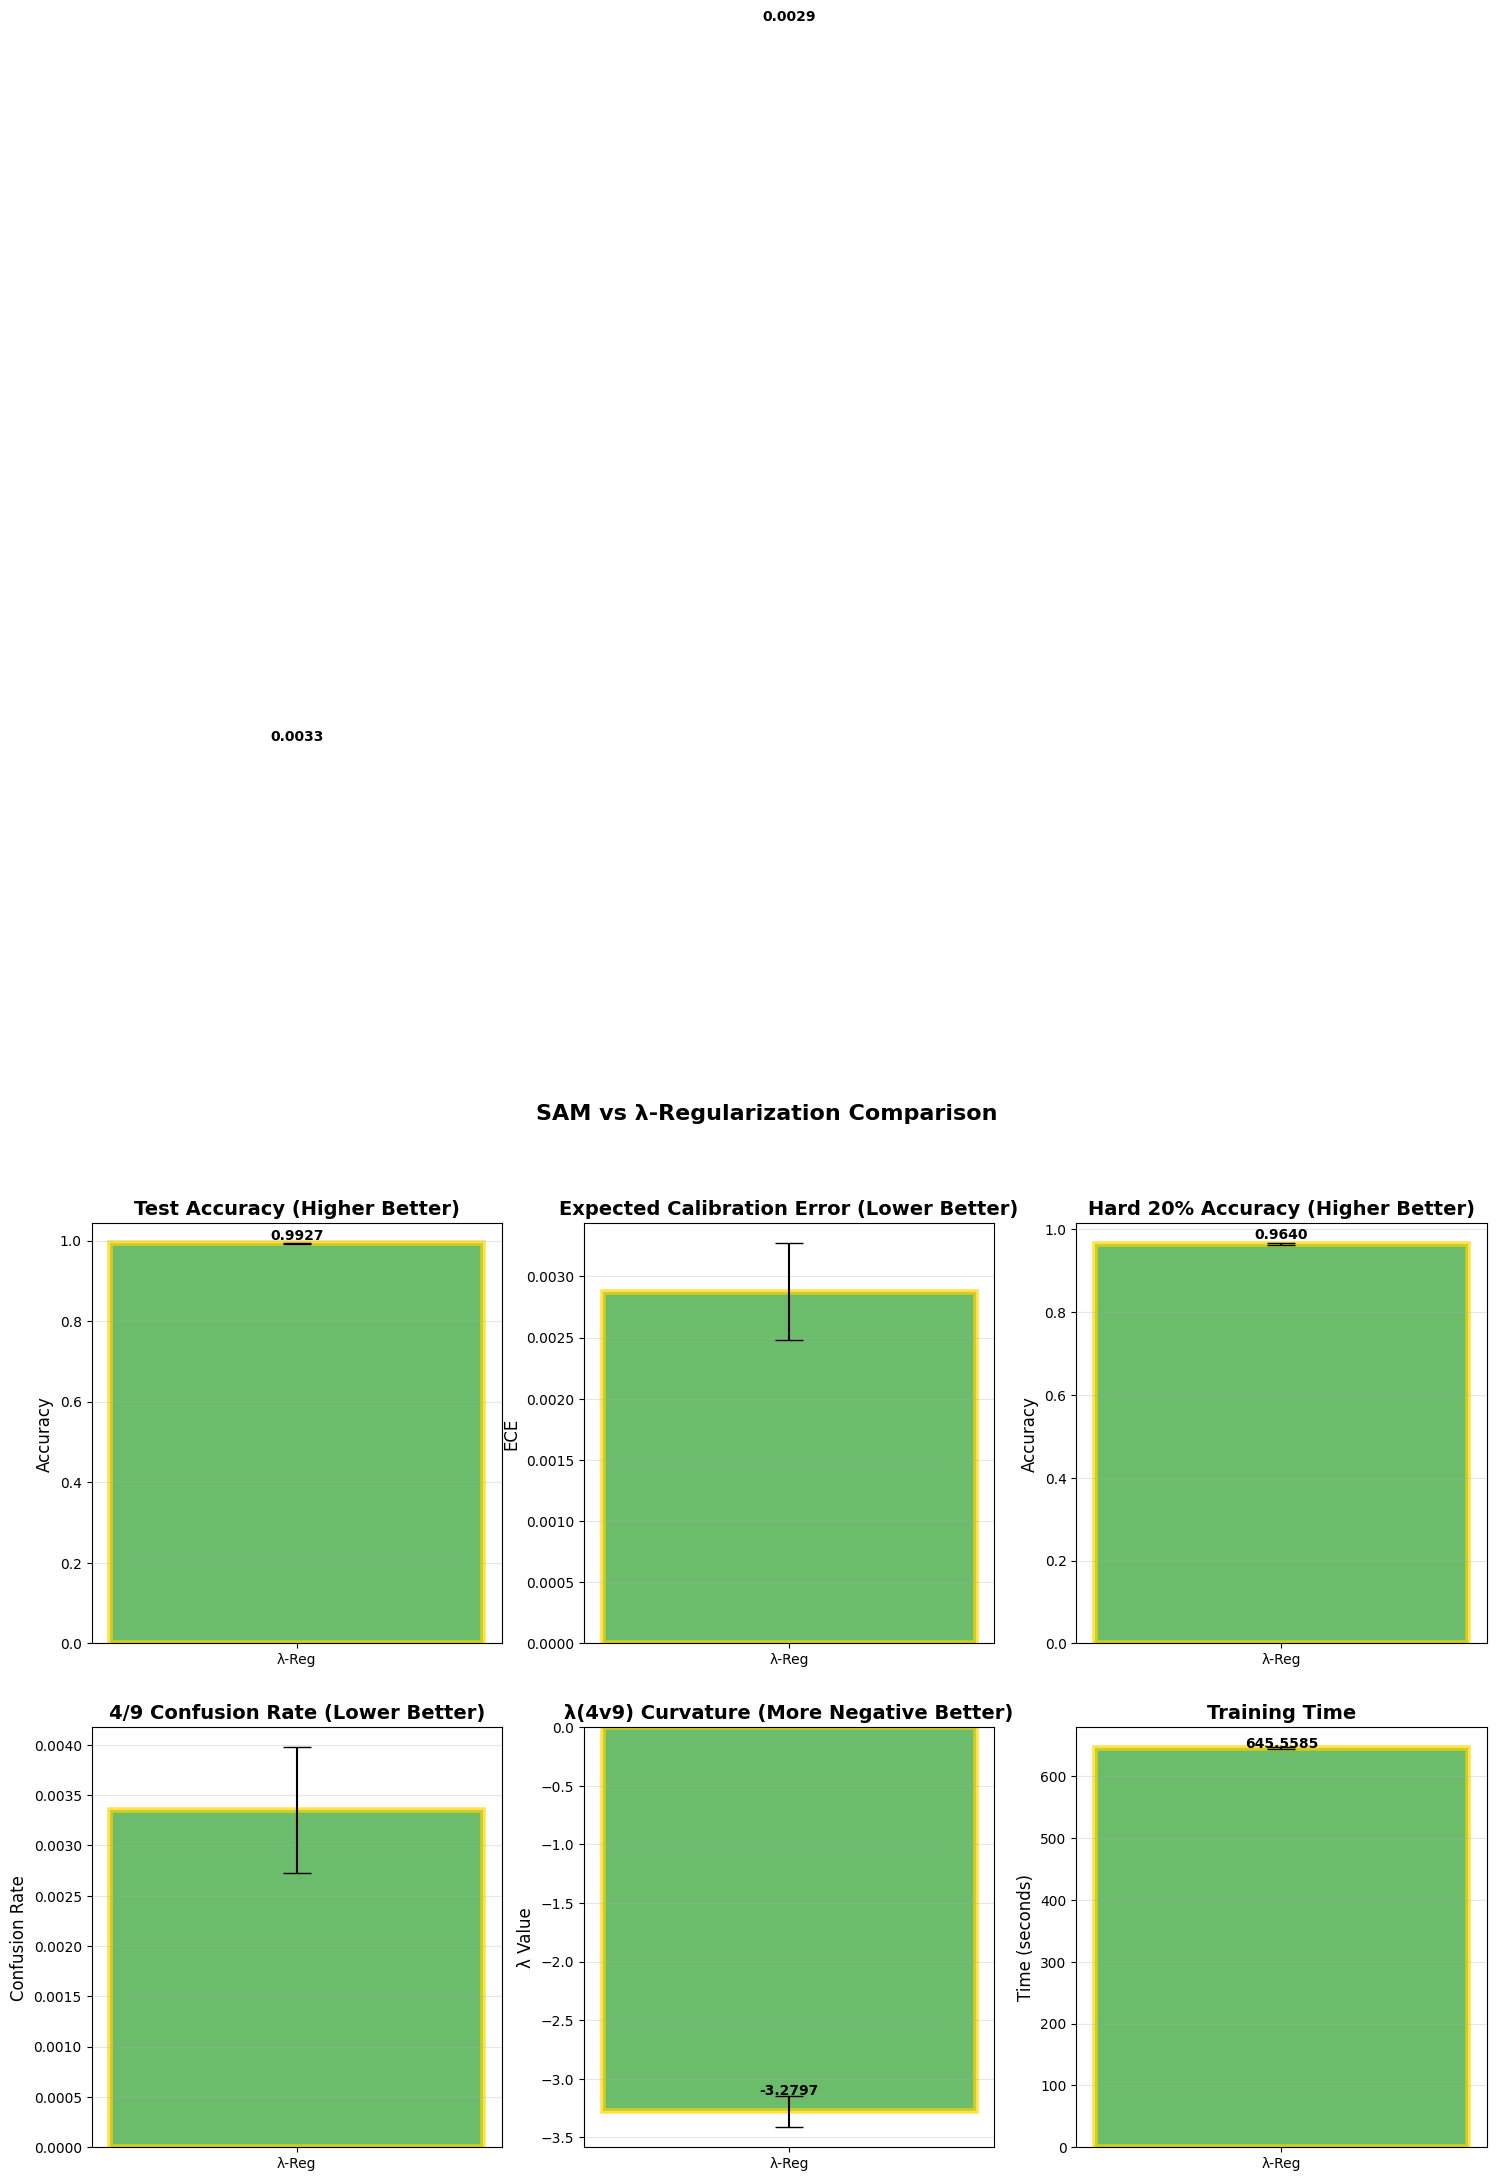

In [22]:
def run_sam_vs_lambda_comparison(seeds=[0, 1, 2], epochs=15,
                                  sam_rho=0.05, lambda_scale=100.0,
                                  lambda_start_n=1, lambda_end_n=3,
                                  verbose=True):
    """
    Run complete comparison: SAM vs λ-regularization.

    Args:
        seeds: List of random seeds to use
        epochs: Number of training epochs
        sam_rho: SAM perturbation radius
        lambda_scale: Lambda regularization strength
        lambda_start_n: Starting derivative order for lambda (default: 1)
        lambda_end_n: Ending derivative order for lambda (default: 3)
        verbose: Print detailed progress

    Returns:
        results: List of ComparisonResult objects
    """
    print("\n" + "="*80)
    print("SAM VS λ-REGULARIZATION COMPARISON")
    print("="*80)
    print(f"\nSettings:")
    print(f"  Seeds: {seeds}")
    print(f"  Epochs: {epochs}")
    print(f"  SAM rho: {sam_rho}")
    print(f"  Lambda scale: {lambda_scale}")
    print(f"  Lambda derivative orders: {lambda_start_n}-{lambda_end_n}")
    print("="*80)

    # Load data
    train_loader, test_loader, test_dataset = load_mnist_full(
        batch_size=128,
        label_noise=0.0,  # 20% label noise to match your experiments
        seed=42
    )

    results = []

    # Train models for each seed
    for seed in seeds:
        print(f"\n{'='*80}")
        print(f"SEED {seed}")
        print(f"{'='*80}")


        # ========== TRAIN WITH LAMBDA ==========
        start_time = time.time()
        lambda_model, lambda_history = train_with_lambda(
            train_loader, test_loader,
            epochs=epochs, lr=1e-3, reg_scale=lambda_scale,
            start_n=lambda_start_n, end_n=lambda_end_n,
            seed=seed, verbose=verbose
        )
        lambda_time = time.time() - start_time

        # Evaluate Lambda model
        lambda_result = evaluate_model_comprehensive(
            lambda_model, test_loader, test_dataset,
            method_name='Lambda', seed=seed, train_time=lambda_time
        )
        results.append(lambda_result)

        # Clean up
        del lambda_model
        torch.cuda.empty_cache()

    return results


comparison_results_lambda_only = run_sam_vs_lambda_comparison(
    seeds=[0, 1, 2],
    epochs=30,
    sam_rho=0.05,        # Standard SAM rho value
    lambda_scale=200.0,  # Your λ regularization strength
    lambda_start_n=1,    # Specify which derivative orders to penalize
    lambda_end_n=4,      # Default: 1st through 3rd order
    verbose=True
)

# Analyze and visualize results
print_comparison_summary(comparison_results_lambda_only)
plot_comparison(comparison_results_lambda_only)